In [1]:
#Install require packages
#!pip install numpy
#!pip install pandas
#!pip install seaborn
#!pip install plotly
#!pip install scikit-learn


import numpy as np
import pandas as pd
import pandas_profiling
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os

from datetime import date, timedelta

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', -1)

## Design :  ibex <br />  <br /> Platform: sky130hd, asap7

A sample dataset with multiple runs varying the core utilization for the floorplan and the place density for global placement for the ibex_core design on sky130hd and asap7 platforms. All design metrics from the runs are collected for analysis.

Metrics data is represented as json files in the  METRICS2.1 format. Each experiment in the run is a separate json file. All of the files are read into a DataFrame 'json_df'.

* Rows of the DataFrame represent an experiment.
* Columns of the DataFrame represent the metrics.

In [2]:
json_df = pd.DataFrame()
path = './metrics/asap7_metrics_runMassive'
for filename in glob.glob(os.path.join(path, '*.json')):
    with open(os.path.join(os.getcwd(), filename), 'r') as f:
        data = f.read()
    data_json = json_normalize(json.loads(data))
    json_df = json_df.append(data_json)
    
path = './metrics/sky130hd_metrics_runMassive'
for filename in glob.glob(os.path.join(path, '*.json')):
    with open(os.path.join(os.getcwd(), filename), 'r') as f:
        data = f.read()
    data_json = json_normalize(json.loads(data))
    json_df = json_df.append(data_json)

In [3]:
print(f'Number of runs in the dataset: {json_df.shape[0]}')
print(f'Number of metrics in each data: {json_df.shape[1]}')

Number of runs in the dataset: 4590
Number of metrics in each data: 93


* The columns in the DataFrame, which are the metrics colleced for each run.

In [4]:
json_df.columns

Index(['run.flow__generate__date', 'run.flow__metrics__version',
       'run.flow__openroad__version', 'run.flow__openroad__commit',
       'run.flow__scripts__commit', 'run.flow__uuid', 'run.flow__design',
       'run.flow__platform', 'run.flow__platform__commit', 'run.flow__variant',
       'synth.design__instance__stdcell__count',
       'synth.design__instance__stdcell__area', 'synth.runtime__total',
       'synth.cpu__total', 'synth.mem__peak', 'constraints.clocks__count',
       'constraints.clocks__details',
       'floorplan.design__restruct__stdcell__count__pre',
       'floorplan.design__restruct__stdcell__count__post',
       'floorplan.design__restruct__stdcell__area__pre',
       'floorplan.design__restruct__stdcell__area__post',
       'floorplan.timing__setup__tns', 'floorplan.timing__setup__ws',
       'floorplan.design__instance__stdcell__area',
       'floorplan.design__instance__design__util',
       'floorplan.design__io__count',
       'floorplan.design__instance__

**Data Engineering**
* Extract only the relevant columns -- for this exercise, get the design name, platform, flow variant and route metrics including runtime and memory footprint.
* Parse the variant string and extract the relevant features  -- Core Utilization and Place Density
* Rename columns to more meaningful names.
* Create new columns (features) based on other column values -- for e.g. Success/Fail for the global and detailed router.

In [6]:
# Data Engineering, extract the relevant metrics
metrics_df = json_df[['run.flow__design',
                      'run.flow__platform',
                      'run.flow__variant',
                      'globalroute.timing__setup__ws',
                      'detailedroute.route__wirelength',
                      'detailedroute.route__via__count',
                      'detailedroute.route__drc_errors__count',
                      'detailedroute.runtime__total',
                      'detailedroute.mem__peak'
]]

In [7]:
metrics_df = metrics_df.rename({
    'run.flow__design' : 'Design',
    'run.flow__platform' : 'Platform',
    'run.flow__variant' : 'Variant',
    'globalroute.timing__setup__ws' : 'GR WNS',
    'detailedroute.route__wirelength' : 'Wire Length',
    'detailedroute.route__via__count' : 'Vias',
    'detailedroute.route__drc_errors__count' : 'DRC Errors',
    'detailedroute.runtime__total' : 'Route Runtime',
    'detailedroute.mem__peak' : 'Peak Mem'
}, axis=1)


* Print the head of the data frame. As we can see, all of the parameter values used in the experiment is in the "Variant" string.  We will have to parse the string and create individual columns for the features we are interested in. For this experiment the only values changing for each run is the Core Utilization and the Place Density. So we extract those and store and column entries in the data frame

In [8]:
metrics_df.head()

,Design,Platform,Variant,GR WNS,Wire Length,Vias,DRC Errors,Route Runtime,Peak Mem
0,ibex,asap7,UTIL_44-AR_1.0-GAP_10-PD_LB_ADD_0.5-GR_OVERFLOW_0,ERR,ERR,ERR,ERR,ERR,ERR
0,ibex,asap7,UTIL_53-AR_1.0-GAP_10-PD_LB_ADD_0.68-GR_OVERFLOW_0,ERR,ERR,ERR,ERR,ERR,ERR
0,ibex,asap7,UTIL_48-AR_1.0-GAP_10-PD_LB_ADD_0.4-GR_OVERFLOW_0,ERR,ERR,ERR,ERR,ERR,ERR
0,ibex,asap7,UTIL_43-AR_1.0-GAP_10-PD_LB_ADD_0.84-GR_OVERFLOW_0,ERR,ERR,ERR,ERR,ERR,ERR
0,ibex,asap7,UTIL_52-AR_1.0-GAP_10-PD_LB_ADD_0.46-GR_OVERFLOW_0,ERR,ERR,ERR,ERR,ERR,ERR


* Create new columns for whether the global router and detailed router completed successfully.

In [9]:
metrics_df['GR Success'] = metrics_df['Success'] = True
metrics_df.loc[metrics_df['GR WNS'] == 'N/A','GR Success'] = False
metrics_df.loc[metrics_df['GR WNS'] == 'ERR','GR Success'] = False

metrics_df.loc[metrics_df['DRC Errors'] == 'ERR','Success'] = False
metrics_df.loc[metrics_df['Wire Length'] == 'N/A','Success'] = False
metrics_df.loc[metrics_df['Wire Length'] == 'ERR','Success'] = False
metrics_df.loc[metrics_df['Route Runtime'] == 'N/A','Success'] = False

(2, 3)
Success  Platform  False  True
0        asap7     1567   728 
1        sky130hd  2043   252 


Index(['Platform', False, True], dtype='object', name='Success')

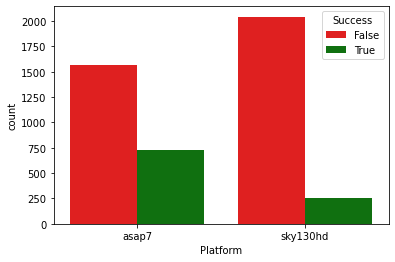

In [10]:
#metrics_df.groupby(['Platform']).Success.value_counts().plot.bar();
dfu = metrics_df.groupby(['Platform']).Success.value_counts().unstack().reset_index()
print(dfu.shape)
print(dfu)
g = sns.countplot(data=metrics_df, x='Platform', hue='Success', palette=["red", "green"])
dfu.columns

* We can see from the above plot that asap7 platform had a lot more successes than sky130hd for the same parameter settings

* In the OpenROAD flow, layer_adjust is used to derate the routing supply of global route, so as to provide more relaxed guides to the detailed router. Using  higher layer_adjust values makes the global router more pessimistic and could result in over congestion during global route, whereas using lower layer_adjust values could make the global router more aggressive and creates guides for the detailed router that can cause DRC error or increased run times during detailed route.

* Lets examine the number of false positives by the Global router, i.e. global router completes but detailed router fails

In [11]:
df = metrics_df[(metrics_df['GR Success'] == True) & (metrics_df['Success'] == False)]['Platform'].value_counts()
print(df)
df

asap7    265
Name: Platform, dtype: int64


asap7    265
Name: Platform, dtype: int64

* As we can see from the above data all of the false positives are in asap7

In [12]:
#metrics_df.iloc[0]['Variant']

In [13]:
def parse_variant(val):
    variants = val.split("-")
    v_dict = dict()
    for i in range(len(variants)):
        key_val = variants[i].rsplit('_',1)
        v_dict[key_val[0]] = float(key_val[1])
    return pd.Series([v_dict['UTIL'], v_dict['AR'], v_dict['GAP'], v_dict['PD_LB_ADD'], v_dict['GR_OVERFLOW']])

In [14]:
metrics_df[['Core Util', 'Aspect Ratio', 'GAP', 'Place Density', 'GR_OVERFLOW']] = metrics_df['Variant'].apply(parse_variant)

* Extract individual features from the "Variant" string. For this experiment we are interested in only the Core Utilization and the Layer Adjust parameters
* Print the head of the dataframe after extracting the features and performing further data engineering.  This data frame is now ready to be used.  Notice that we have also created additional columns for capturing whether Global Route and Detailed Route completed. 

In [15]:
asap7_df = metrics_df[(metrics_df['Platform'] == 'asap7')]
sky130hd_df = metrics_df[(metrics_df['Platform'] == 'sky130hd')]

In [16]:
asap7_s = asap7_df[asap7_df['Success'] == True]
asap7_s['Place Density'] = asap7_s['Place Density'] * 100.0
sky130hd_s = sky130hd_df[sky130hd_df['Success'] == True]
sky130hd_s['Place Density'] = sky130hd_s['Place Density'] * 100.0

In [17]:
a_df = pd.DataFrame(asap7_s.groupby('Core Util')['Place Density'].max()).reset_index()
s_df = pd.DataFrame(sky130hd_s.groupby('Core Util')['Place Density'].max()).reset_index()

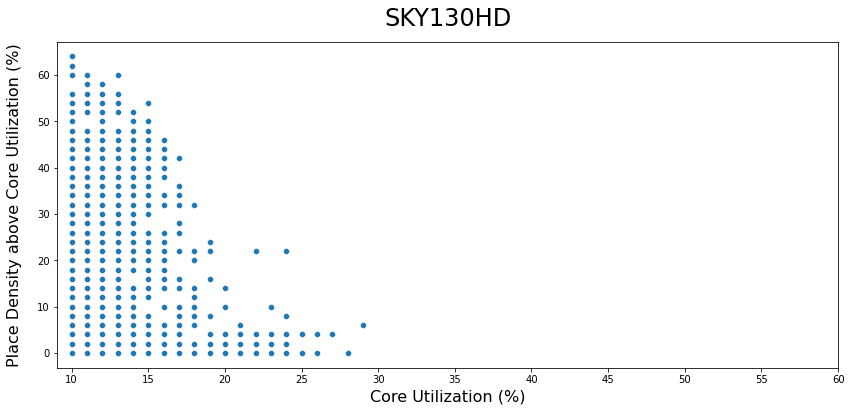

In [18]:
fig,ax = plt.subplots(figsize=(14,6))
g = sns.scatterplot(data = sky130hd_s, x = 'Core Util', y = 'Place Density', ax=ax)
ax.set_xlabel('Core Utilization (%)', size=16)
ax.set_ylabel('Place Density above Core Utilization (%)', size=16, labelpad=15)
ax.set_xticks(np.arange(10, 65, 5))
ax.set_title('SKY130HD', y = 1.03, size=24)
fig.show()

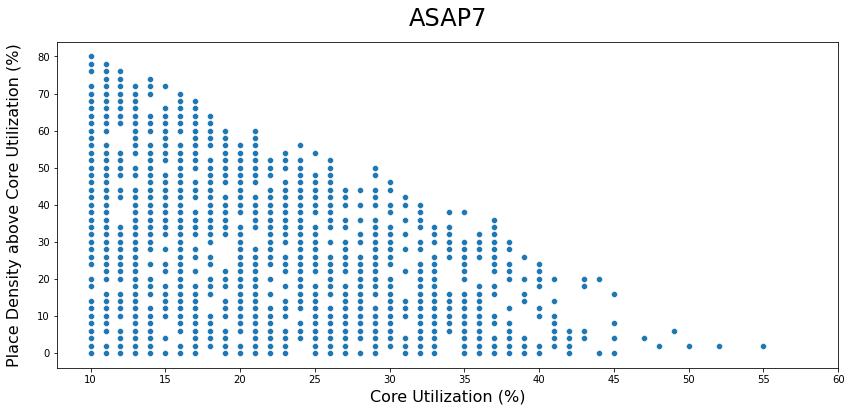

In [19]:
fig,ax = plt.subplots(figsize=(14,6))
g = sns.scatterplot(data = asap7_s, x = 'Core Util', y = 'Place Density', ax=ax)
ax.set_xlabel('Core Utilization (%)', size=16)
ax.set_ylabel('Place Density above Core Utilization (%)', size=16, labelpad=15)
ax.set_xticks(np.arange(10,65,5))
ax.set_title('ASAP7', y = 1.03, size=24)
fig.show()

In [22]:
success_df = metrics_df[metrics_df['Success'] == True]
failure_df = metrics_df[metrics_df['Success'] == False]
success_df = success_df.astype({'Design' : 'string',
                               'Variant' : 'string',
                                'GR WNS' : 'float',
                                'Vias'   : 'int',
                                'DRC Errors' : 'int',
                                'Wire Length' : 'float',
                                'Route Runtime' : 'string',
                                'Peak Mem' : 'float'
                               })

* Let us examine the scatter plot of success/failures for the two platforms.

Text(0.5, 1.0, 'asap7')

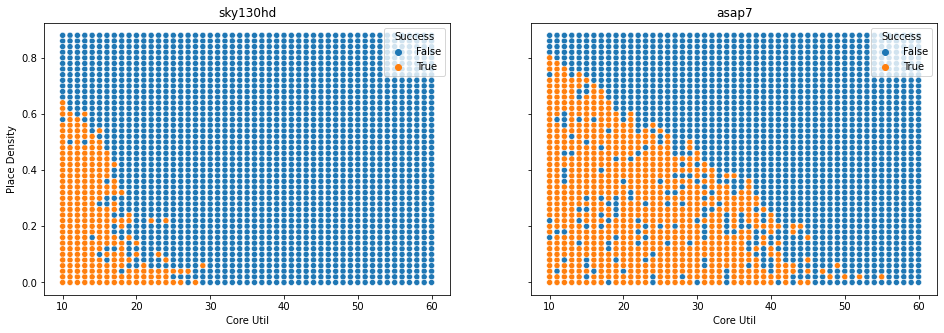

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(16,5)

s1 = sns.scatterplot(data=metrics_df[metrics_df['Platform'] == 'sky130hd'], x = 'Core Util',
                     y = 'Place Density', hue = 'Success', ax = ax1)
s2 = sns.scatterplot(data=metrics_df[metrics_df['Platform'] == 'asap7'], x = 'Core Util',
                     y = 'Place Density', hue = 'Success', ax = ax2);
s1.set_title("sky130hd")
s2.set_title("asap7")

In [25]:
!jupyter nbconvert --to html --no-input --TemplateExporter.exclude_input=True --no-prompt METRICS2.1-exp4.ipynb

[NbConvertApp] Converting notebook METRICS2.1-exp4.ipynb to html
[NbConvertApp] Writing 1142856 bytes to METRICS2.1-exp4.html
